In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import numpy as np
import optics_rig as orig
from scipy.interpolate import interp1d
from scipy import signal as signal
from scipy.stats import gamma, burr12, triang, logistic, norm, skewnorm, johnsonsb
from scipy.optimize import curve_fit

from iteration_utilities import flatten

import os
import glob
from scipy import optimize
import copy
import dill

import colorcet as cc
 
from scipy.integrate import trapezoid as trapz

from spikes_statistics import *


from scipy.optimize import curve_fit

from fitter import Fitter, get_common_distributions, get_distributions

from scipy.special import erf

In [2]:
pd.options.display.max_columns = None # this is to see all columns of pandas dataframes

In [3]:
DDIL = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/'
DPLOTS = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Plots/'
DWAP_EX = '/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/WAP_Extracted/'


## Check typical descent speed 

In [4]:
fn = DDIL + '20240210.dil'
dil = orig.load_dill(fn)

In [5]:
# dil.keys()

In [6]:
# dil['ctd'].plot(y='pres', xlim=[0, 1e6], figsize=[10,2])
# plt.grid()

In [7]:
# compute descent speed in cm/s
i100 = np.where(dil['ctd']['pres'] >= 100)[0][0]
i300 = np.where(dil['ctd']['pres'] >= 300)[0][0]
print(str(np.round((dil['ctd']['pres'].values[i300]-dil['ctd']['pres'].values[i100])*100/((dil['ctd'].index[i300]-dil['ctd'].index[i100])/1000),2)) + " cm/s")

39.91 cm/s


In [8]:
fns = np.sort(glob.glob(DDIL + '*.dil'))

In [9]:
fn = fns[10]
fn

'/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Optics_rig/Processed/20240208.dil'

## Read dil file

In [12]:
dil = orig.load_dill(fn)

## Create RBR dataframe with re-zeroed index

In [13]:
rbr = dil['rbr']
# rbr.describe()

<Axes: xlabel='msec'>

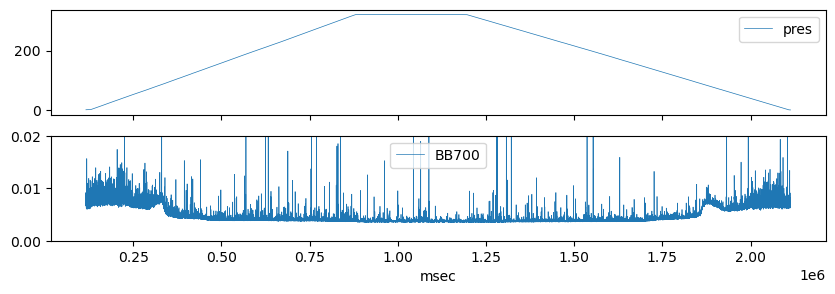

In [14]:
fig, ax = plt.subplots(2,1, figsize=[10,3], sharex=True)
rbr.plot(y='pres', lw=0.5, ax=ax[0])
rbr.plot(y='BB700', lw=0.5, ax=ax[1], ylim=[0, 0.02])

## Extract descending profile

In [15]:
imaxpres = np.where( rbr['pres'] >= rbr['pres'].max()-5 )[0][0]
iminpres = np.where( rbr['pres'] >= 5 )[0][0]

rbr = rbr.iloc[iminpres:imaxpres]
rbr['msec_rbr'] = rbr['msec_rbr'].values - rbr['msec_rbr'].values[0] # compute values for new index
rbr.set_index('msec_rbr', inplace=True) # reset index


/var/folders/98/ls269b9j6jq4z03kb9n9hxj40000gn/T/ipykernel_57753/2534102867.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbr['msec_rbr'] = rbr['msec_rbr'].values - rbr['msec_rbr'].values[0] # compute values for new index


## Estimate descent rate

In [16]:
print(f"~{np.median(np.diff(rbr['pres']) / np.diff(rbr.index)) * 1000 * 100:4.1f} cm/sec")

~42.8 cm/sec


<Axes: xlabel='msec_rbr'>

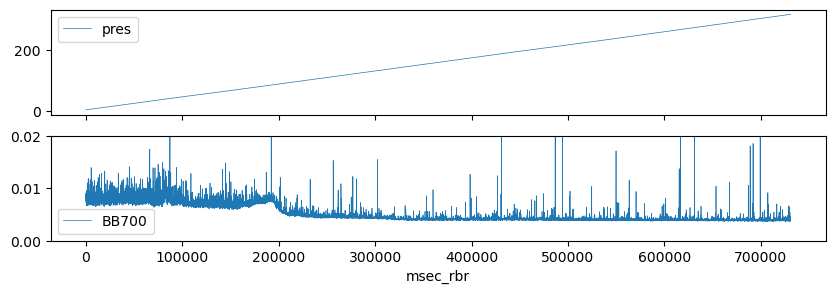

In [17]:
fig, ax = plt.subplots(2,1, figsize=[10,3], sharex=True)
rbr.plot(y='pres', lw=0.5, ax=ax[0])
rbr.plot(y='BB700', lw=0.5, ax=ax[1], ylim=[0, 0.02])

### Estimate profile sampling rate in 1/seconds

In [18]:
sampling_rate = np.round(1/np.nanmedian(np.diff(rbr.index)) * 1000)  # [sample/sec]
print(str(sampling_rate) + ' samples/second')

32.0 samples/second


## Estimates baseline and spikes for entire descending profile

### Define bin size in seconds

In [19]:
dt = 40 # [sec]  Note: for a typical ascent rate of 10 cm/s, this is dt*10 cm or dt/10 m

### Define bins for histogram

In [20]:
N_bins = int(25/40*dt) # for one 40-sec section of a profile I had estimated that 25 bins was a reasonable number, so now I apply this factor to all sections
print('number of bins ' + str(N_bins))

bins = np.linspace(-6, -2, N_bins)

number of bins 25


## Divide profile in time bins

In [21]:
rbr = create_bin_index(rbr, dt)

/Users/gdal/Dropbox/Project/PICCOLO/Cruise/Data/Source/PSD_mode/spikes_statistics.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rbr['bin'] = np.floor(rbr.index.values/(1000*dt))


## Create dataframe for binned results

In [22]:
cols = np.asarray(['pres', 'baseline', 'p1', 'p16', 'p50', 'p84', 'p100', 'N_spikes'] + [f'{b:<-5.02f}' for b in bins]).flatten()
rbr_binned = pd.DataFrame(data=None, index=rbr.bin.unique(), columns=cols)
# rbr_binned

## Add pressures to bins

In [23]:
### Other way to bin profile
grs = with_pandas_groupby(np.mean, rbr['pres'], rbr['bin'])
binned_pres = []
for igr, gr in enumerate(grs):
    binned_pres.append(grs.get_group(igr).mean())
    
rbr_binned['pres'] = binned_pres

# Extract data from one bin

In [24]:
for ibin in np.unique(rbr['bin'].values):
    rbr_binned = get_binned_BB(rbr, int(ibin), rbr_binned, bins, METHOD="Nathan")

In [25]:
rbr_binned.head()

,pres,baseline,p1,p16,p50,p84,p100,N_spikes,-6.00,-5.83,-5.67,-5.50,-5.33,-5.17,-5.00,-4.83,-4.67,-4.50,-4.33,-4.17,-4.00,-3.83,-3.67,-3.50,-3.33,-3.17,-3.00,-2.83,-2.67,-2.50,-2.33,-2.17,-2.00
0.0,13.450493,0.007821,-2.860243,-2.830796,-2.728152,-2.498423,-2.216111,122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,53.0,31.0,15.0,5.0,0.0
1.0,30.479420,0.00786,-2.815278,-2.774652,-2.659262,-2.40803,-2.020688,117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,34.0,22.0,6.0,2.0
2.0,47.410104,0.007371,-2.932554,-2.877493,-2.724094,-2.505182,-1.902738,188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,63.0,42.0,19.0,9.0,0.0
3.0,63.962540,0.006725,-3.094764,-3.048659,-2.860819,-2.642704,-2.093502,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,56.0,59.0,23.0,8.0,4.0,2.0
4.0,80.760657,0.007319,-2.894823,-2.860307,-2.749758,-2.392947,-0.853939,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,22.0,10.0,4.0,3.0,0.0


# Plot binned data

## Plot histograms of log-spikes

In [26]:
N_time_bins = np.unique(rbr['bin'].values).size

In [27]:
delta_bin = np.floor(np.median(np.diff(rbr_binned['pres'].values)))

Text(0.5, 0, 'Log BB spike')

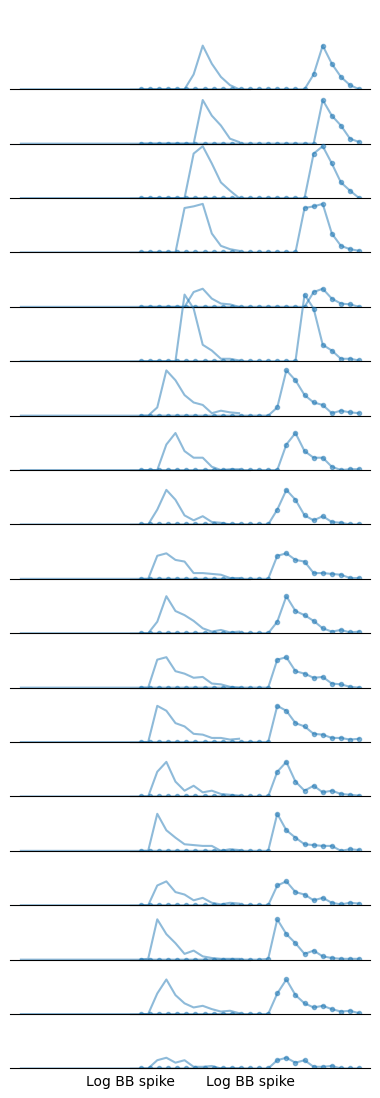

In [28]:
fig, ax = plt.subplots(N_time_bins, 2, figsize=[6,16], sharex=True, sharey=True)

for ibin in np.unique(rbr['bin'].values.astype(int)):
    # print(ibin)
    rbr_binned.iloc[ibin,8:].plot(ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5, ax=ax[ibin, 0])   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
    ax[ibin, 0].set_position([0.2,                               # left
                          0.06 - ibin * 0.02 * delta_bin/10,  # bottom
                          0.4,                                # width
                          0.05 ])                             # height

    ax[ibin, 0].set_facecolor('none')
    ax[ibin, 0].spines[['left', 'right', 'top']].set_visible(False)
    
    
    ax[ibin, 0].tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
    )
    ax[ibin, 0].tick_params(
        axis='y',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelleft=False
    )

    
ax[ibin, 0].set_xlabel('Log BB spike')







for ibin in np.unique(rbr['bin'].values.astype(int)):

    rbr_binned.iloc[ibin,8:].plot(marker='.', ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5, ax=ax[ibin, 1])   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
    ax[ibin, 1].set_position([0.4,                               # left
                          0.06 - ibin * 0.02 * delta_bin/10,  # bottom
                          0.4,                                # width
                          0.05 ])                             # height

    ax[ibin, 1].set_facecolor('none')
    ax[ibin, 1].spines[['left', 'right', 'top']].set_visible(False)
    
    
    ax[ibin, 1].tick_params(
        axis='x',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False
    )
    ax[ibin, 1].tick_params(
        axis='y',  # changes apply to the x-axis
        which='both',  # both major and minor ticks are affected
        left=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelleft=False
    )

    
ax[ibin, 1].set_xlabel('Log BB spike')

## Plot percentiles of log-spikes

In [29]:
# fig, ax = plt.subplots(N_time_bins, 1, figsize=[2,16], sharex=True, sharey=True)

# for ibin in np.unique(rbr['bin'].values.astype(int)):
#     # print(ibin)
#     rbr_binned.iloc[ibin,8:].plot(ax=ax[ibin], ylim=[0, rbr_binned.iloc[:,8:].values.max()*1.2], alpha=0.5)   #title=str(rbr_binned.loc[ibin, 'pres']), 
    
#     ax[ibin].set_position([0.2,                               # left
#                           0.06 - ibin * 0.02 * delta_bin/10,  # bottom
#                           0.8,                                # width
#                           0.05 ])                             # height

#     ax[ibin].set_facecolor('none')
#     ax[ibin].spines[['left', 'right', 'top']].set_visible(False)
    
    
#     ax[ibin].tick_params(
#         axis='x',  # changes apply to the x-axis
#         which='both',  # both major and minor ticks are affected
#         bottom=False,  # ticks along the bottom edge are off
#         top=False,  # ticks along the top edge are off
#         labelbottom=False
#     )
#     ax[ibin].tick_params(
#         axis='y',  # changes apply to the x-axis
#         which='both',  # both major and minor ticks are affected
#         left=False,  # ticks along the bottom edge are off
#         top=False,  # ticks along the top edge are off
#         labelleft=False
#     )

    
# ax[ibin].set_xlabel('Log BB spike')

In [30]:
time_bin = 0

rbr_smpl = rbr.loc[rbr['bin']==time_bin]

## Extract baseline

rbr_binned.loc[time_bin, 'baseline'] = np.nanpercentile(rbr_smpl['BB700'].values, 50)
# rbr_baseline

## Extract spikes and log-transform them
rbr_spikes = get_spikes(rbr_smpl['BB700'].values, METHOD='Nathan')
rbr_spikes_log = np.log10(rbr_spikes)  # this is proportional to DIAMETER

## Extract log-spike percentiles
prct_pos = np.asarray([1, 16, 50, 84, 100])
rbr_binned.iloc[time_bin, 2:7] = np.nanpercentile(rbr_spikes_log, prct_pos)

## Compute how many spikes
# compute how many spikes after removing nans
rbr_binned.loc[time_bin, 'N_spikes'] = len(rbr_spikes_log[~np.isnan(rbr_spikes_log)])

# Extract histogram
tmp = function_hist(rbr_spikes_log, np.insert(bins, 0, -7))
rbr_binned.iloc[time_bin, 8:] = tmp[0]

## Plot spikes

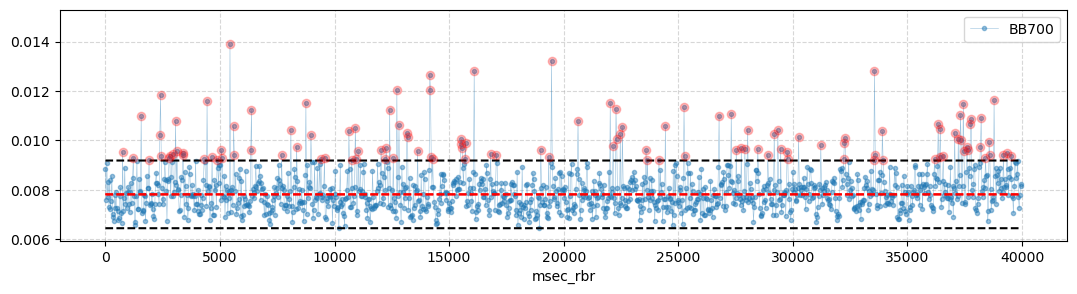

In [31]:
fig, ax = plt.subplots()

rbr_smpl.plot(y='BB700', lw=0.4, marker='o', markersize=3, figsize=[13,3], ylim=[rbr_smpl['BB700'].min() - 0.0005, np.percentile(rbr_smpl['BB700'], 100)*1.1], alpha=0.45, ax=ax)

ax.plot(rbr_smpl.index,  np.median(rbr_smpl['BB700']) * np.ones(rbr_smpl['BB700'].index.size), 'r--')
ax.plot(rbr_smpl.index,  ( np.median(rbr_smpl['BB700']) + ( np.median(rbr_smpl['BB700']) - np.min(rbr_smpl['BB700']) ) ) * np.ones(rbr_smpl.index.size), 'k--')
ax.plot(rbr_smpl.index,  np.min(rbr_smpl['BB700']) * np.ones(rbr_smpl.index.size), 'k--')

ax.plot(rbr_smpl.index,  np.median(rbr_smpl['BB700']) * np.ones(rbr_smpl.index.size), 'r--')

ispikes = np.where(rbr_spikes>0)[0]
ax.plot(rbr_smpl.iloc[ispikes].index,  rbr_smpl.iloc[ispikes]['BB700'], lw=0, marker='o', markersize=6, c='r', alpha=0.25)

ax.grid(ls='--', alpha=0.5)

Text(0.5, 0, 'S_{G} corrected')

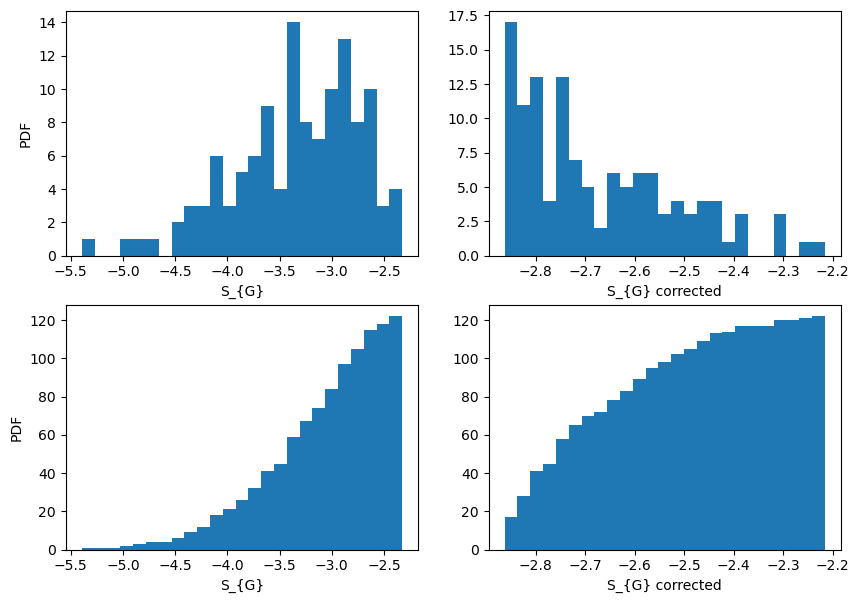

In [32]:
fig, ax = plt.subplots(2,2, figsize=[10,7])

rbr_spikes_G = get_spikes(rbr_smpl['BB700'].values, METHOD='grg')
rbr_spikes_log_G = np.log10(rbr_spikes_G)  

rbr_spikes_N = get_spikes(rbr_smpl['BB700'].values, METHOD='Nathan')
rbr_spikes_log_N = np.log10(rbr_spikes_N)  
rbr_spikes_log_N = rbr_spikes_log_N[~np.isnan(rbr_spikes_log_N)]

noise = np.nanmedian(rbr_smpl['BB700']) - np.nanmin(rbr_smpl['BB700'])
rbr_spikes_log_N2G = rbr_spikes_log_N + np.log10(1 - noise / (10**rbr_spikes_log_N))
rbr_spikes_log_G2N = np.log10(10**rbr_spikes_log_G + noise )


ax[0,0].hist(rbr_spikes_log_G, N_bins, cumulative=False, density=False)
ax[0,0].set_xlabel(r'S_{G}')
ax[0,0].set_ylabel(r'PDF')

ax[0,1].hist(rbr_spikes_log_G2N, N_bins, cumulative=False, density=False)
ax[0,1].set_xlabel(r'S_{G} corrected')

ax[1,0].hist(rbr_spikes_log_G, N_bins, cumulative=True, density=False)
ax[1,0].set_xlabel(r'S_{G}')
ax[1,0].set_ylabel(r'PDF')

ax[1,1].hist(rbr_spikes_log_G2N, N_bins, cumulative=True, density=False)
ax[1,1].set_xlabel(r'S_{G} corrected')



In [33]:
noise

0.0013681325000000008

In [34]:
np.nanmedian(rbr_smpl['BB700']) - np.nanmin(rbr_smpl['BB700'])

0.0013681325000000008

## Fit distribution

0
           sumsquare_error       aic        bic    kl_div  ks_statistic  \
johnsonsb          0.04838  6.826651 -936.37238  0.002779      0.048458   

           ks_pvalue  
johnsonsb   0.923438  


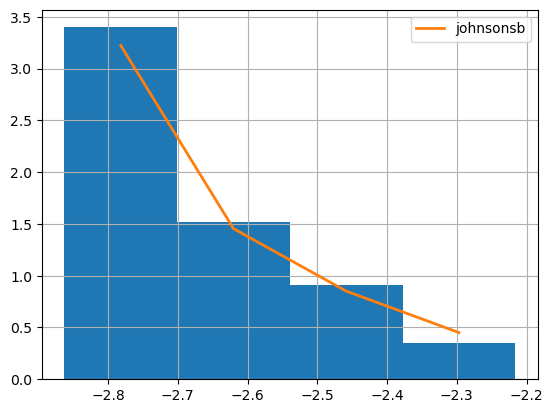

In [35]:


for time_bin in range(N_time_bins):

    # extract data for this bin
    rbr_smpl = rbr.loc[rbr['bin']==time_bin]

    ## Extract spikes and log-transform them
    rbr_spikes = get_spikes(rbr_smpl['BB700'].values, METHOD='Nathan');
    rbr_spikes_log = np.log10(rbr_spikes)


    ## Extract baseline
    rbr_binned.loc[time_bin, 'baseline'] = np.nanpercentile(rbr_smpl['BB700'].values, 50) # rbr_baseline
    
    ## Extract log-spike percentiles
    prct_pos = np.asarray([0, 16, 50, 84, 100])
    rbr_binned.iloc[time_bin, 2:7] = np.nanpercentile(rbr_spikes_log, prct_pos)

    
    bins_ = np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log), 5)#N_bins)

    y = rbr_spikes_log[~np.isnan(rbr_spikes_log)]

    f = Fitter(y,
               distributions=[
                   # 'burr12',
               #     # 'norm',
               #     # 'logistic',
               #     'triang',
               #     'skewnorm',
                   'johnsonsb',
               ],
               bins=bins_,
               density=False,
               # distributions=get_distributions(),
               # timeout=60
              )
    f.fit()
    print(time_bin)
    print(f.summary(Nbest=3, plot=True))
    
    break

In [36]:
# f.summary()

In [37]:
p = f.fitted_param['johnsonsb']

In [38]:
np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log), 4)

array([-2.86259129, -2.64709801, -2.43160473, -2.21611146])

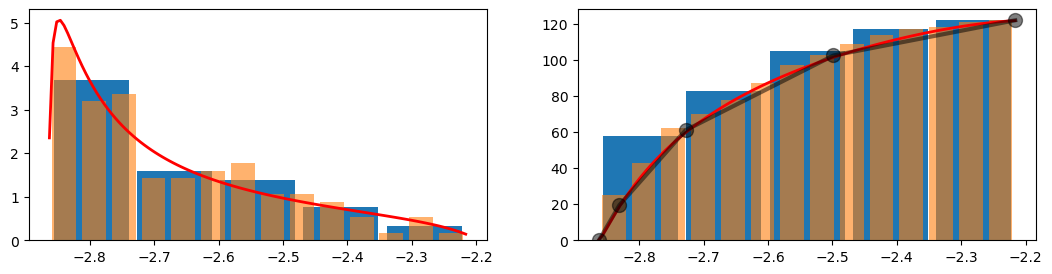

In [39]:
# Example of Nathan's spikes with Nathan's bins
x = np.linspace(bins_.min(), bins_.max(), 115)
bins_ = np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log),  6)

# bins_ = np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log), 7)

fig, ax = plt.subplots(1,2, figsize=[13,3])

ax[0].hist(rbr_spikes_log, bins=bins_, density=True, rwidth=0.9)
ax[0].hist(rbr_spikes_log, bins=np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log),  15), density=True, rwidth=0.8, alpha=0.6) 

# density bool, default: False
# If True, draw and return a probability density: each bin will display the bin's raw count divided by 
# the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))), 
# so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.

ax[0].plot(x, johnsonsb.pdf(x, *p), c='r', lw=2) 

# ax[0].plot(x, triang.pdf(x, c, loc, scale), c='r') 

ax[1].hist(rbr_spikes_log, bins=bins_, cumulative=True, rwidth=0.9)
ax[1].hist(rbr_spikes_log, bins=np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log),  15), rwidth=0.8, alpha=0.6, cumulative=True)

ax[1].plot(x, johnsonsb.cdf(x, *p) * rbr_binned.iloc[0]['N_spikes'], c='r', lw=2) 

ax[1].plot(rbr_binned.iloc[0,2:7], np.asarray([0, 16, 50, 84, 100]) / 100 * rbr_binned.iloc[0]['N_spikes'], 'ko-', ms=10, lw=3, alpha=.5)


# Thoughts on "Nathan's method" to transmit binned log-spike distributions

## Nathan's proposed (if I understood well) method:
1. Median of BB in the time bin (baseline) [1/7, cum. 1/7]
2. Log-transformed values of minimun and maximum spike heights values [2/7, cum. 3/7]
3. Counts for the minimum and maximum values [2/7, cum. 5/7]
4. Counts for two (equally spaced? log spaced?) bins that can be back-calculated from min and max [2/7, cum. 7/7]

## Giorgio's proposed method:
1. Median of BB in the time bin (baseline) [1/7, cum. 1/7]
2. 5 percentiles (including 0^th and 100^th) of log-transformed spikes [5/7, cum. 6/7]
3. Total number of spikes (this is needed to reconstruct the distribution in absolute values) [1/7, cum. 7/7]

## Summary
If the above is correct, then grg's method should provide one bin more than Nathan's method.

## Other problems to think about
- What type of spikes should we use? Nathan's or Giorgio's
- How can I convert the 5 percetiles + N_spikes into a CDF?
- Is it a problem that we have different bins in the same profile?
- How can the float bin binned-data sent by the sensor? (this would be very useful to save on tramsission times)





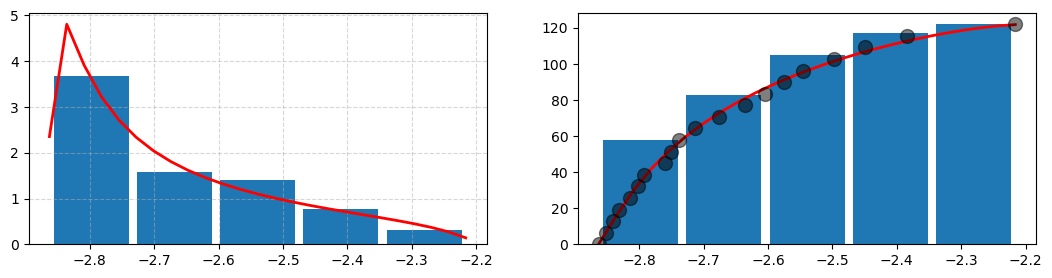

In [40]:
N_bins_ = 5 + 1

# Example of Nathan's spikes with percentiles
time_bin = 0

# extract data for this bin
rbr_smpl = rbr.loc[rbr['bin']==time_bin]

## Extract spikes and log-transform them
method = 'Nathan'
rbr_spikes = get_spikes(rbr_smpl['BB700'].values, METHOD=method);
rbr_spikes_log = np.log10(rbr_spikes)


bins_ = np.linspace(np.nanmin(rbr_spikes_log), np.nanmax(rbr_spikes_log), N_bins_)
x = np.linspace(bins_.min(), bins_.max(), 25)

## Extract baseline
rbr_binned.loc[time_bin, 'baseline'] = np.nanpercentile(rbr_smpl['BB700'].values, 50) # rbr_baseline

## Extract log-spike percentiles
if method == 'Nathan':
    prct_pos = np.asarray([0, 30, 60, 85, 100])
    prct_pos = np.linspace(0, 100, 20)
else:
    prct_pos = np.asarray([0, 5, 35, 65, 100])
    

# rbr_binned.iloc[time_bin, 2:7] = np.nanpercentile(rbr_spikes_log, prct_pos)
rbr_prctiles = np.nanpercentile(rbr_spikes_log, prct_pos)

y = rbr_spikes_log[~np.isnan(rbr_spikes_log)]
f = Fitter(y,
           distributions=['johnsonsb'],
           bins=bins_,
           density=False,
           # distributions=get_distributions(),
           # timeout=60
          )
f.fit()

p = f.fitted_param['johnsonsb']

fig, ax = plt.subplots(1,2, figsize=[13,3])

# density bool, default: False
# If True, draw and return a probability density: each bin will display the bin's raw count divided by 
# the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))), 
# so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.
ax[0].hist(rbr_spikes_log, bins=bins_, density=True, rwidth=0.9)  # see above about "density" argument
ax[0].plot(x, johnsonsb.pdf(x, *p), c='r', lw=2) 
ax[0].grid(ls='--', alpha=0.5)

ax[1].hist(rbr_spikes_log, bins=bins_, cumulative=True, rwidth=0.9)
ax[1].plot(x, johnsonsb.cdf(x, *p) * rbr_binned.iloc[time_bin]['N_spikes'], c='r', lw=2) # note use of `*p` to automatically unpack `f_.fitted_param['johnsonsb']`
ax[1].plot(rbr_prctiles, prct_pos / 100 * rbr_binned.iloc[time_bin]['N_spikes'], 'ko', ms=10, lw=3, alpha=.5)


# fit percentiles to obtain 

# curve_fit(fit_cdf_johnsonsb, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)

# fig, ax2 = plt.subplots(1)
# ax2.plot(x, johnsonsb.cdf(x, *f_.fitted_param['johnsonsb']) * rbr_binned.iloc[time_bin]['N_spikes'], c='k', marker='s', lw=2) 

# Fit percentiles to selected CDF

In [41]:
def cdf_johnsonsb(x, a, b, loc, scale):
    
    cdf = johnsonsb.cdf(x, a, b, loc, scale)
    
    return cdf

In [42]:
cdf_johnsonsb(-2.7, *p)

0.5502323802320505

In [43]:
p

(0.8456468627186426, 0.6396238651700985, -2.864949171214363, 0.672886647604686)

In [44]:
xdata = rbr_prctiles
ydata = prct_pos / 100 * rbr_binned.iloc[time_bin]['N_spikes']

p_fitted = curve_fit(cdf_johnsonsb, xdata, ydata, p0=p, method='trf' )  # 'lm', ‘dogbox’ 'trf'
p_fitted[0]

array([ 0.97480538,  0.5434773 , -3.59993687,  0.45975239])

In [45]:
from scipy.optimize import minimize

In [46]:
def obj(x, y, pars, fun):
    
    y_pred = fun(x, y, pars)
    
    cost = np.sum( np.abs( y_pred - y  ) ) / np.count(y)
    
    return cost

In [47]:
minimize(obj, x0 = [ 0.97480538,  0.5434773 , -3.59993687,  0.45975239], method='Nelder-Mead', tol=1e-6)

TypeError: obj() missing 3 required positional arguments: 'y', 'pars', and 'fun'

In [ ]:
# https://stackoverflow.com/questions/30135587/how-to-use-scipy-optimize-minimize

def obj(arguments): #"""objective function, to be solved."""
    
    arg_1, arg_2, arg_3, arg_4 = arguments[0], arguments[1], arguments[2], arguments[3]
    # v_3 = f(x, arg_1, arg_2)
    v_3 = cdf_johnsonsb(x, arg_1, arg_2, arg_3, arg_4)
    
    return np.mean(abs(x - v_3))

x0 = 1

initial_guess = [0.97480538,  0.5434773 , -3.59993687,  0.45975239]  # initial guess can be anything

result = minimize(obj, initial_guess, method='Nelder-Mead')
result.x

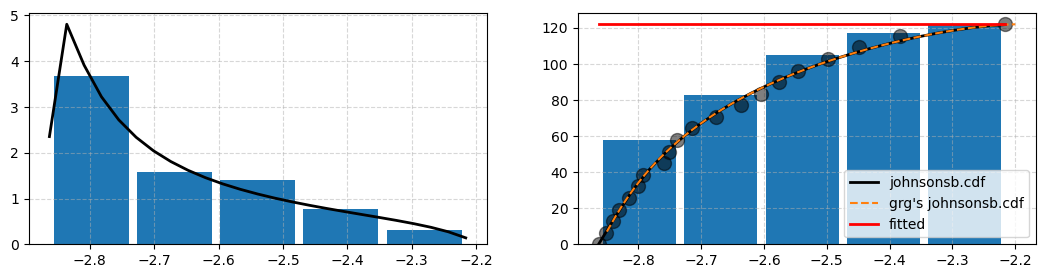

In [48]:
x__ = np.linspace(-2.85, -2.2, 389)

fig, ax = plt.subplots(1,2, figsize=[13,3])

ax[0].hist(rbr_spikes_log, bins=bins_, density=True, rwidth=0.9)  # see above about "density" argument
ax[0].plot(x, johnsonsb.pdf(x, *p), c='k', lw=2)
ax[0].grid(ls='--', alpha=0.5)

ax[1].hist(rbr_spikes_log, bins=bins_, cumulative=True, rwidth=0.9)
ax[1].plot(rbr_prctiles, prct_pos / 100 * rbr_binned.iloc[time_bin]['N_spikes'], 'ko', ms=10, lw=3, alpha=.5)

ax[1].plot(x, johnsonsb.cdf(x, *p) * rbr_binned.iloc[time_bin]['N_spikes'], c='k', lw=2, label='johnsonsb.cdf')
ax[1].plot(x__, cdf_johnsonsb(x__, *p) * rbr_binned.iloc[time_bin]['N_spikes'], ls='--', label='grg\'s johnsonsb.cdf')
ax[1].plot(x, johnsonsb.cdf(x, *p_fitted[0]) * rbr_binned.iloc[time_bin]['N_spikes'], c='r', lw=2, label='fitted')

ax[1].legend()

ax[1].grid(ls='--', alpha=0.5)

In [49]:
f.fitted_param['johnsonsb']

(0.8456468627186426, 0.6396238651700985, -2.864949171214363, 0.672886647604686)

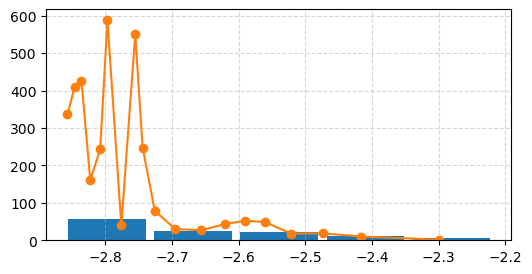

In [50]:
plt.close('all')
x_ = rbr_prctiles
y_ = prct_pos #/ 100 * rbr_binned.iloc[0]['N_spikes']

x_rcstr_lin = x_[:-1] + np.diff(x_) / 2
pdf_rcstr_lin = np.diff(y_) / np.diff(x_)




fig, ax = plt.subplots(1, figsize=[6,3])

ax.hist(rbr_spikes_log, bins=bins_, density=False, rwidth=0.9)

ax.plot(x_rcstr_lin, pdf_rcstr_lin / rbr_binned.iloc[time_bin]['N_spikes'] / np.diff(x_), 'o-' )

ax.grid(ls='--', alpha=0.5)

# TO DO

## - Do we need to optimize which percentiles we want?
## - Test on several profiles: 
## ----- What is the best type of distribution?
## ----- Do we need 5 percentiles or could we use less (and thus free-up space for CHL spikes)?


# Problems to solve
## - How to compute spikes?
- grg: `sp_grg = raw - med - noise > 0`
- nathan: `sp_nat = raw - med > noise`
- In theory they are equivalent, IF we save `noise = med - min = percentile(Sp_grg, 0)`
- `log10(sp_grg) = log10(sp_nat) + log10(1 - noise/sp_nat)`
- `log10(sp_nat) = log10(10^{log10(sp_grg)} + noise)`
## - How to represent spike distribution? (it depends on answer to question above)
## - How to bin spikes in the sensor so that the float can bin them as well?

# More thoughts
## Regarding amount of data transmitted
If we sample with three channels (standard mode) at high resolution (1 m), then for a 2000-m profile we will have 6000 datapoints to transmit (a lot).

If we sample in psd mode, we would have 18000 points to transmit.

We really need a way to 
- either have the float bin data coming from the sensor
- or control the sensor binning period

If we could bin data every 10 metres below the productive zone (~> 200 m) and keep 1-m resolution above, then we would have (200 + 1800/10) * 9 = 3420 data points, instead of 18000. </br>
Binning data every 5 m in the prod zone and every 20 m in th emesopelagic would decrease the total number to 1170.



### Compute how many data points we could get with a given CTS5 binning

In [483]:
surf_depth_range = 200 # [dbar]
meso_deth_range = 1800 # [dbar]

surf_binning = 5 # [dbar]
meso_binning = 30 # [dbar]

n_channels = np.asarray([9, 20])

n_points = (surf_depth_range / surf_binning + meso_deth_range / meso_binning) * n_channels
n_points

array([ 900., 2000.])

In [484]:
(200/5 + 1800/40) * 20

1700.0

In [492]:
import sys 
sys.version

'3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) \n[Clang 16.0.6 ]'